In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/yelp-chi-merged/yelp_CHI.csv


# Импорт библиотек

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, auc, roc_auc_score, classification_report
# from imblearn.under_sampling import ClusterCentroids
from sklearn.decomposition import PCA

import scipy as sp

import cupy
import cuml
import cudf

!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [3]:
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'Times New Roman'

# Датасет

In [4]:
df_origin = cudf.read_csv('/kaggle/input/yelp-chi-merged/yelp_CHI.csv')
df_origin

,Unnamed: 0,date,review_id,user_id,prod_id,label,useful,funny,cool,rating,review
0,0,9/22/2012,0LpVTc3,TRKxLC3y-ZvP45e5iilMtw,pbEiXam9YJL3neCYHGwLUA,1,0,0,0,5,"Unlike Next, which we'd eaten at the previous ..."
1,1,9/19/2012,tljtLzf68Fkwf,0EMm8umAqXZzyhxNpL4M9g,pbEiXam9YJL3neCYHGwLUA,1,0,0,2,3,Probably one of the best meals I've had ever. ...
2,2,9/6/2012,iSN,DlwexC7z88ymAzu45skODw,pbEiXam9YJL3neCYHGwLUA,1,3,0,8,3,Service was impeccable. Experience and present...
3,3,9/9/2012,Jmwrh7,kW2dk1CWihmh3g7k9N2G8A,pbEiXam9YJL3neCYHGwLUA,1,0,2,1,5,"The problem with places like this, given the e..."
4,4,8/30/2012,lKlceLWoePzeuvFD3sj4mw,HxXEcMDDTJFUqVfhPF9M8Q,pbEiXam9YJL3neCYHGwLUA,1,1,1,3,5,I have no idea how to write my review - dining...
...,...,...,...,...,...,...,...,...,...,...,...
61533,61533,10/29/2008,-oWeNtZ2jdKS,CtHKKxsRoWl-9KuYPoG3RA,fHJRHfeLQl-MxUSdUkI9rg,1,0,0,0,5,I've passed this place a bunch of times on my ...
61534,61534,10/8/2011,BOxgSHru1VycS,kHIFPG3NLehDo-6uRUjWYA,_KI0Y2UO68kJuTFUKucaXQ,1,0,0,1,5,Rubino's is not really setup as a retail opera...
61535,61535,4/7/2012,I6pazvTPUqRtU,fUXNHG4x1AN9oPpBSpCtUw,_KI0Y2UO68kJuTFUKucaXQ,1,1,0,0,5,This place is amazing. The food is great and y...
61536,61536,6/5/2009,gu7FbL,QQCm2oqSnnz24Z-yHeMtxQ,_KI0Y2UO68kJuTFUKucaXQ,1,0,1,1,4,OK went back the next day as I was driving by ...


In [5]:
df = df_origin.copy()
df

,Unnamed: 0,date,review_id,user_id,prod_id,label,useful,funny,cool,rating,review
0,0,9/22/2012,0LpVTc3,TRKxLC3y-ZvP45e5iilMtw,pbEiXam9YJL3neCYHGwLUA,1,0,0,0,5,"Unlike Next, which we'd eaten at the previous ..."
1,1,9/19/2012,tljtLzf68Fkwf,0EMm8umAqXZzyhxNpL4M9g,pbEiXam9YJL3neCYHGwLUA,1,0,0,2,3,Probably one of the best meals I've had ever. ...
2,2,9/6/2012,iSN,DlwexC7z88ymAzu45skODw,pbEiXam9YJL3neCYHGwLUA,1,3,0,8,3,Service was impeccable. Experience and present...
3,3,9/9/2012,Jmwrh7,kW2dk1CWihmh3g7k9N2G8A,pbEiXam9YJL3neCYHGwLUA,1,0,2,1,5,"The problem with places like this, given the e..."
4,4,8/30/2012,lKlceLWoePzeuvFD3sj4mw,HxXEcMDDTJFUqVfhPF9M8Q,pbEiXam9YJL3neCYHGwLUA,1,1,1,3,5,I have no idea how to write my review - dining...
...,...,...,...,...,...,...,...,...,...,...,...
61533,61533,10/29/2008,-oWeNtZ2jdKS,CtHKKxsRoWl-9KuYPoG3RA,fHJRHfeLQl-MxUSdUkI9rg,1,0,0,0,5,I've passed this place a bunch of times on my ...
61534,61534,10/8/2011,BOxgSHru1VycS,kHIFPG3NLehDo-6uRUjWYA,_KI0Y2UO68kJuTFUKucaXQ,1,0,0,1,5,Rubino's is not really setup as a retail opera...
61535,61535,4/7/2012,I6pazvTPUqRtU,fUXNHG4x1AN9oPpBSpCtUw,_KI0Y2UO68kJuTFUKucaXQ,1,1,0,0,5,This place is amazing. The food is great and y...
61536,61536,6/5/2009,gu7FbL,QQCm2oqSnnz24Z-yHeMtxQ,_KI0Y2UO68kJuTFUKucaXQ,1,0,1,1,4,OK went back the next day as I was driving by ...


# Предобработка

In [6]:
# функция предобработки текста
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_review(text):
    cl_text = text.lower().strip()
    cl_text = re.sub(r"[^\w\s]", "", cl_text)
    words = word_tokenize(cl_text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

example = 'this is the (test) example for preprocessing function 123 8done 8 :!?!'
print(preprocess_review(example))

test example preprocessing function 123 8done 8


In [7]:
df= df.drop(['Unnamed: 0', 'user_id',	'prod_id', 'date'], axis=1)
df

,review_id,label,useful,funny,cool,rating,review
0,0LpVTc3,1,0,0,0,5,"Unlike Next, which we'd eaten at the previous ..."
1,tljtLzf68Fkwf,1,0,0,2,3,Probably one of the best meals I've had ever. ...
2,iSN,1,3,0,8,3,Service was impeccable. Experience and present...
3,Jmwrh7,1,0,2,1,5,"The problem with places like this, given the e..."
4,lKlceLWoePzeuvFD3sj4mw,1,1,1,3,5,I have no idea how to write my review - dining...
...,...,...,...,...,...,...,...
61533,-oWeNtZ2jdKS,1,0,0,0,5,I've passed this place a bunch of times on my ...
61534,BOxgSHru1VycS,1,0,0,1,5,Rubino's is not really setup as a retail opera...
61535,I6pazvTPUqRtU,1,1,0,0,5,This place is amazing. The food is great and y...
61536,gu7FbL,1,0,1,1,4,OK went back the next day as I was driving by ...


In [8]:
df_cpu = df.to_pandas()

In [9]:
df_cpu['review'] = df_cpu['review'].apply(preprocess_review)

In [10]:
df = cudf.from_pandas(df_cpu)
df

,review_id,label,useful,funny,cool,rating,review
0,0LpVTc3,1,0,0,0,5,unlike next wed eaten previous night dish comp...
1,tljtLzf68Fkwf,1,0,0,2,3,probably one best meal ive ever performance fo...
2,iSN,1,3,0,8,3,service impeccable experience presentation coo...
3,Jmwrh7,1,0,2,1,5,problem place like given exhorbitant cost medi...
4,lKlceLWoePzeuvFD3sj4mw,1,1,1,3,5,idea write review dining alinea brings whole d...
...,...,...,...,...,...,...,...
61533,-oWeNtZ2jdKS,1,0,0,0,5,ive passed place bunch time way olympic northw...
61534,BOxgSHru1VycS,1,0,0,1,5,rubinos really setup retail operation price in...
61535,I6pazvTPUqRtU,1,1,0,0,5,place amazing food great beat price unfortunat...
61536,gu7FbL,1,0,1,1,4,ok went back next day driving lunchtime steak ...


# Методы визуализации метрик

In [11]:
def show_metrics(y_true, y_pred, title):
    print(f'''
                {title}
==========================================
 auc: {roc_auc_score(y_true, y_pred)}             
==========================================
 report:                                
{classification_report(y_true, y_pred)}
==========================================

    ''')

In [12]:
def show_confusion_matrix(y_true, y_pred, title_string):
    conf = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,8))
    plt.title(title_string)
    sns.heatmap(conf, fmt='d', annot=True)
    plt.savefig(title_string+'_confusion_matrix.png')
    plt.show()

In [13]:
# show_metrics([1,0,1,1,0], [1,0,1,1,0],'test example')

In [14]:
# show_confusion_matrix([1,0,1,1,0], [1,0,1,1,0], 'test_example')

In [15]:
from sklearn.metrics import (
    roc_auc_score, 
    accuracy_score, 
    precision_score,
    recall_score, 
    f1_score, 
    classification_report,
    confusion_matrix,
    average_precision_score
)

def show_classification_report(y_true, y_pred):
    """
    Выводит основные метрики классификации в консоль
    
    Параметры:
    y_true - истинные метки
    y_pred - предсказанные метки
    """
    y_test_numpy, y_pred_numpy = cupy.asnumpy(y_true), cupy.asnumpy(y_pred)
    
    # Вычисляем метрики
    accuracy = accuracy_score(y_test_numpy, y_pred_numpy)
    precision = precision_score(y_test_numpy, y_pred_numpy)
    recall = recall_score(y_test_numpy, y_pred_numpy)
    f1 = f1_score(y_test_numpy, y_pred_numpy)
    roc_auc = roc_auc_score(y_test_numpy, y_pred_numpy)  # Используем бинарные предсказания

    print(f'''
    Accuracy:{accuracy:.4f} 
    Precision:{precision:.4f}
    Recall:{recall:.4f}
    F1: {f1:.4f}
    AUC: {roc_auc:.4f}
    
    ''')


# TF-IDF векторизация

In [16]:
stop_words = stopwords.words('english')
temp = [preprocess_review(word) for word in stop_words]
stop_words = stop_words + [word for word in temp if word != '']
# print(stop_words)

In [17]:
from cuml.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,1), max_features=1000)
X_tfidf = vectorizer.fit_transform(df['review'])
y = df['label']
# review_vector_test = vectorizer.transform(x_test['review'])

In [18]:
print(type(X_tfidf),
      X_tfidf.shape,
      y.shape)

<class 'cupyx.scipy.sparse._csr.csr_matrix'> (61538, 1000) (61538,)


# Kmeans балансировка

In [19]:
from cuml import KMeans
from cuml.metrics import pairwise_distances
import cupy as cp

# Функция для андерсемплинга класса
def cluster_centroids_majority_KMeans(
    X_majority,
    y_majority,
    n_samples_per_cluster,
    n_clusters=3,
    n_init=10,
    max_iter=300,
):
    # Инициализация KMeans
    estimator = KMeans(n_clusters=n_clusters, random_state=42, max_iter=max_iter, n_init=n_init, verbose=True, )
    
    X_majority_df = cudf.DataFrame(X_majority.todense(), index=y_majority.index)  # Преобразуем в dense
    # X_majority_df.index = y_majority.index #
    x_cupy = X_majority_df.to_cupy()  # Преобразуем в cupy
    print(f'X_cupy: {x_cupy}')
    print(f'X_cupy размерность: {x_cupy.shape}')
    
    print(f'Индексы X_majority_df: {X_majority_df.index}')
    print("---------------------------------")
    print(f'Индексы y: {y_majority.index}')
    print(f'''
    Размерности: 
      X: {X_majority_df.shape}
      y: {y_majority.shape}
      
    ''')
    print((X_majority_df.index == y_majority.index).sum())
    estimator.fit(x_cupy)
    
    cluster_labels = estimator.predict(x_cupy)  # Берем метки

    
    print(f'метки кластера: {cluster_labels}' )
    print(f'метки кластера размерность: {cluster_labels.shape}')
    print(f'метки кластера индексы: {cudf.Series(cluster_labels).index}')
    print(f'количество точек кластера 0 {(cluster_labels==0).sum()}')
    print(f'количество точек кластера 1 {(cluster_labels==1).sum()}')
    print(f'количество точек кластера 2 {(cluster_labels==2).sum()}')
    
    centroids = cp.array(estimator.cluster_centers_)  # Берем центры кластеров
    
    # Вычисляем расстояния до центроидов
    distances = pairwise_distances(x_cupy, centroids, metric='euclidean')

    # Создаем cudf.DataFrame для работы с индексами
    df = cudf.DataFrame(index=y_majority.index)
    # df.index = y_majority.index
    df['index'] =  y_majority.index
    df['cluster'] = cudf.Series(cluster_labels, index=y_majority.index)
    print('Датафрейм с индексами и кластерами:', df)
    print('размерность: ', df['cluster'].shape)
    print('фактическая размерность: ', df.shape)
    print('количество nan: ', df['cluster'].isna().sum())
    print(df)
    sampled_indices = []

    for cluster_id in range(n_clusters):
        # Индексы точек в текущем кластере
        cluster_indices = df[df['cluster'] == cluster_id]['index'].values
        
        if len(cluster_indices) == 0:
            continue
            
        # Расстояния до центроида текущего кластера
        cluster_distances = distances[cluster_indices, cluster_id]
        
        # Сортируем по расстоянию и выбираем первые n_samples_per_cluster
        sorted_indices = cp.argsort(cluster_distances)[:n_samples_per_cluster]
        selected_indices = cluster_indices[sorted_indices]
        
        sampled_indices.append(selected_indices)
    
    sampled_indices = cp.concatenate(sampled_indices)
    print(f'выбранные индексы: {sampled_indices}')
    print(f'выбранные индексы размерность: {sampled_indices.shape}')
    # for ind in sampled_indices.get():
    #     if ind > 321901:
    #         print(df[ind])
    cp.random.shuffle(sampled_indices)
    
    return (
        X_majority_df.loc[sampled_indices.get()],
        y_majority.loc[sampled_indices.get()],
        centroids,
        sampled_indices
    )

In [20]:
n_clusters = 2
n_samples_per_cluster = X_tfidf[y == -1].shape[0]//n_clusters
n_init = 30
max_iter = 300

print('Количество экземпляров мажоритарного класса: ', X_tfidf[y == 1].shape[0])
print('Количество экземпляров миноритарного класса: ', X_tfidf[y == -1].shape[0])
print('Количество экземпляров которые надо взять с каждого кластера: ', n_samples_per_cluster)

#-----#
X_majority_tfidf = X_tfidf[y == 1]
y_majority = y[y == 1]
print(X_majority_tfidf.shape, y_majority.shape)

X_minority_tfidf = X_tfidf[y == -1]
y_minority = y[y == -1]
print(X_minority_tfidf.shape, y_minority.shape)

Количество экземпляров мажоритарного класса:  53397
Количество экземпляров миноритарного класса:  8141
Количество экземпляров которые надо взять с каждого кластера:  4070
(53397, 1000) (53397,)
(8141, 1000) (8141,)


In [21]:
print(y_majority.index) 
print(cudf.DataFrame(X_majority_tfidf.todense()).index)

Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
       ...
       61528, 61529, 61530, 61531, 61532, 61533, 61534, 61535, 61536, 61537],
      dtype='int64', length=53397)
RangeIndex(start=0, stop=53397, step=1)


In [22]:
# ресемплим мажоритарный класс 
x_majority_resampled, y_majority_resampled, centroids, df_indices = cluster_centroids_majority_KMeans(
    X_majority_tfidf,
    y_majority,
    n_samples_per_cluster,
    n_clusters=n_clusters,
    n_init=n_init,
    max_iter=max_iter
    )

X_cupy: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
X_cupy размерность: (53397, 1000)
Индексы X_majority_df: Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
       ...
       61528, 61529, 61530, 61531, 61532, 61533, 61534, 61535, 61536, 61537],
      dtype='int64', length=53397)
---------------------------------
Индексы y: Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
       ...
       61528, 61529, 61530, 61531, 61532, 61533, 61534, 61535, 61536, 61537],
      dtype='int64', length=53397)

    Размерности: 
      X: (53397, 1000)
      y: (53397,)
      
    
53397
метки кластера: [0 0 0 ... 0 0 0]
метки кластера размерность: (53397,)
метки кластера индексы: RangeIndex(start=0, stop=53397, step=1)
количество точек кластера 0 48855
количество точек кластера 1 4542
количество точек кластера 2 0
Датафрейм с индексами 

In [23]:
# print(review_vector_train)

In [24]:
x_majority_resampled

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
42888,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
50187,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.091975,0.0,0.090957,...,0.000000,0.0,0.0,0.0,0.0,0.137554,0.0,0.0,0.0,0.0
27251,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
9986,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.086077,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
27486,0.051053,0.057922,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47712,0.063817,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
41953,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
7848,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
28728,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [25]:
print("Размерность x_majority_resampled:", x_majority_resampled.shape)
print("Количество выбранных индексов:", len(df_indices))

Размерность x_majority_resampled: (8140, 1000)
Количество выбранных индексов: 8140


In [26]:
print(df_indices)
print(y_majority_resampled.value_counts())
print(centroids)

[42888 50187 27251 ...  7848 28728 11043]
label
1    8140
Name: count, dtype: int64
[[0.00586601 0.00395482 0.00398616 ... 0.00210975 0.00558658 0.00648311]
 [0.00421445 0.0035779  0.00331528 ... 0.00013615 0.00587212 0.005635  ]]


In [27]:
type(centroids)

cupy.ndarray

In [28]:
# ! pip install -U kaleido

In [29]:
from cuml.decomposition import PCA
import plotly.express as px
n_components = 2
pca = PCA(n_components=n_components)

x_majority_balanced_reduced = pca.fit_transform(x_majority_resampled)
x_majority_balanced_reduced.columns = ['Компонента 1', 'Компонента 2']
x_majority_balanced_reduced['Тип'] = 'Точка'

centroids_reduced = pca.transform(centroids)
df_centroids = cudf.DataFrame(centroids_reduced, columns=['Компонента 1', 'Компонента 2'])
df_centroids['Тип'] = 'Центр кластера'  # Тип - центроид

df_vis = cudf.concat([x_majority_balanced_reduced, df_centroids])

df_vis_pandas = df_vis.to_pandas()

# print(type(x_majority_balanced_reduced), type(centroids_reduced))
# x_majority_balanced_reduced

fig = px.scatter(df_vis_pandas, x="Компонента 1", y="Компонента 2", color="Тип",
                 title="Кластеризация KMeans на классе настоящих отзывов",
                 labels={"Компонента 1": "Компонента 1", "Компонента 2": "Компонента 2"},
                 opacity=0.7, symbol="Тип")

fig.show()
# fig.write_image('Результат выборки с помощью Kmeans YelpNYC.png')


In [30]:
X_minority_tfidf, y_minority

(<cupyx.scipy.sparse._csr.csr_matrix at 0x7f4f3152d510>,
 53272   -1
 53273   -1
 53274   -1
 53275   -1
 53276   -1
         ..
 61408   -1
 61409   -1
 61410   -1
 61411   -1
 61412   -1
 Name: label, Length: 8141, dtype: int64)

In [31]:
x_majority_resampled, y_majority_resampled

(            0         1    2    3    4    5    6         7    8         9    \
 42888  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.000000   
 50187  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.091975  0.0  0.090957   
 27251  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.000000   
 9986   0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.000000   
 27486  0.051053  0.057922  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.000000   
 ...         ...       ...  ...  ...  ...  ...  ...       ...  ...       ...   
 47712  0.063817  0.000000  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.000000   
 41953  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.000000   
 7848   0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.000000   
 28728  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.000000   
 11043  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.000000   
 
        ...       990  991  992  993  

In [32]:
type(x_majority_resampled), type(X_minority_tfidf), 

(cudf.core.dataframe.DataFrame, cupyx.scipy.sparse._csr.csr_matrix)

In [33]:

x_minority_df = cudf.DataFrame(X_minority_tfidf.todense())
# x_minority_df
x_balanced = cudf.concat([x_majority_resampled, x_minority_df], axis=0).reset_index().drop(['index'], axis=1)
x_balanced

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.091975,0.0,0.090957,...,0.000000,0.0,0.0,0.0,0.0,0.137554,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.086077,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.051053,0.057922,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16276,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
16277,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
16278,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
16279,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [34]:
print(type(y_majority_resampled), type(y_minority))
len(y_majority_resampled), len(y_minority)

y_balanced = cudf.concat([y_majority_resampled, y_minority])
y_balanced = y_balanced.replace(-1, 0)
y_balanced

<class 'cudf.core.series.Series'> <class 'cudf.core.series.Series'>


42888    1
50187    1
27251    1
9986     1
27486    1
        ..
61408    0
61409    0
61410    0
61411    0
61412    0
Name: label, Length: 16281, dtype: int64

In [35]:
# # Создаем случайные индексы
# shuffled_indices = cp.random.permutation(len(x_train_balanced))

# # Перемешиваем X и y
# x_train_balanced = x_train_balanced.iloc[shuffled_indices.get()].reset_index(drop=True)
# y_train_balanced = y_train_balanced.iloc[shuffled_indices.get()].reset_index(drop=True)

In [36]:
from cuml.model_selection import train_test_split

x_train_balanced, x_test_balanced, y_train_balanced, y_test_balanced = train_test_split(x_balanced, 
                                                                                        y_balanced, 
                                                                                        test_size=0.25,
                                                                                       random_state=42)

In [37]:
print('размерность тренировочного набора: ', x_train_balanced.shape, y_train_balanced.shape)
print('размерность тестового набора: ', x_test_balanced.shape, y_test_balanced.shape)


размерность тренировочного набора:  (12211, 1000) (12211,)
размерность тестового набора:  (4070, 1000) (4070,)


In [38]:
y_train_balanced.value_counts()

label
0    6140
1    6071
Name: count, dtype: int64

In [39]:
y_test_balanced.value_counts()

label
1    2069
0    2001
Name: count, dtype: int64

In [40]:
type(x_test_balanced), type(y_test_balanced)

(cudf.core.dataframe.DataFrame, cudf.core.series.Series)

# Модели

In [41]:
from cuml import LogisticRegression
from cuml.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt

def classification_report(y_test, y_pred):
    from sklearn.metrics import classification_report, roc_auc_score
    y_test_numpy, y_pred_numpy = cupy.asnumpy(y_test), cupy.asnumpy(y_pred)
    print(classification_report(y_test_numpy, y_pred_numpy))
    print(f"AUC: {roc_auc_score(y_test_numpy, y_pred_numpy)}")

def show_confusion_matrix(y_true, y_pred, title_string):
    y_true_numpy, y_pred_numpy = cupy.asnumpy(y_true), cupy.asnumpy(y_pred)
    conf = confusion_matrix(y_true_numpy, y_pred_numpy)
    plt.figure(figsize=(12,12))
    plt.title(title_string)
    plt.xlabel('Фактические значения')
    plt.ylabel('Предсказанные моделью значения')
    sns.heatmap(conf, annot=True, fmt='d', linewidths=1)
    plt.savefig(title_string+'_confusion_matrix.png')
    plt.show()
    

## Логистическая регрессия

              precision    recall  f1-score   support

           0       0.92      0.89      0.91      2001
           1       0.90      0.93      0.91      2069

    accuracy                           0.91      4070
   macro avg       0.91      0.91      0.91      4070
weighted avg       0.91      0.91      0.91      4070

AUC: 0.910752453642681


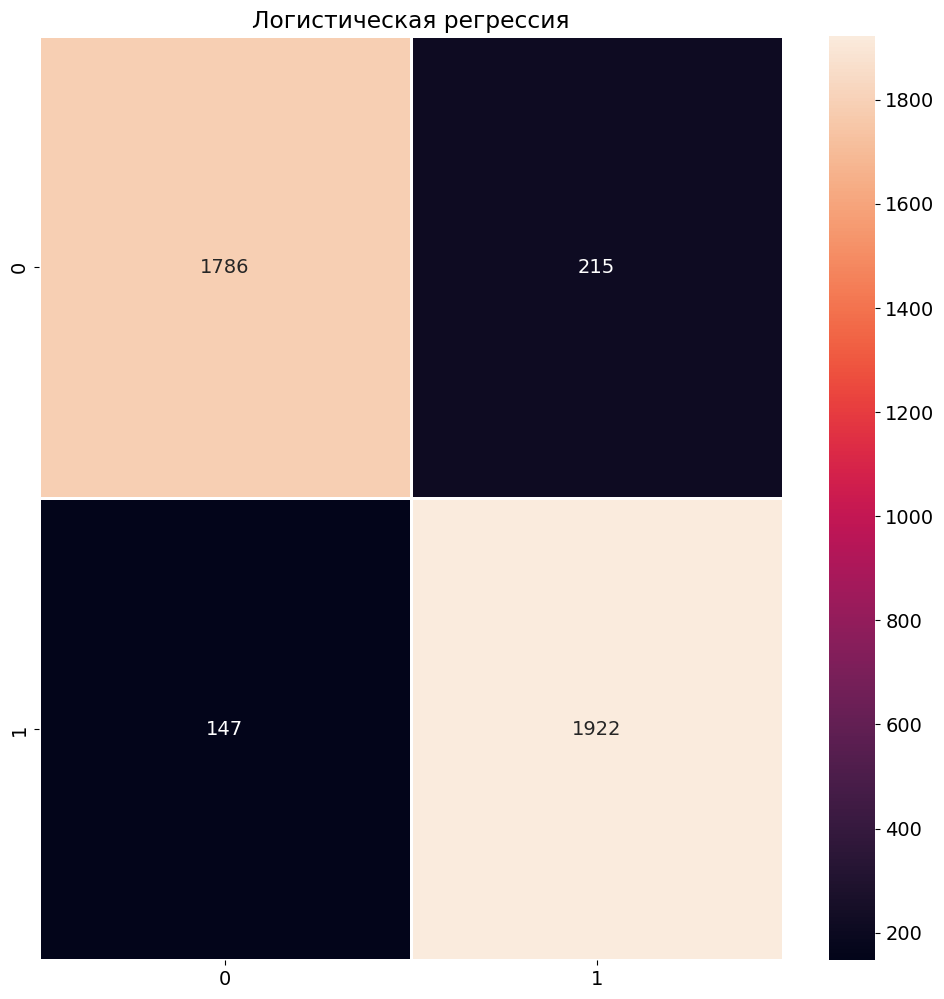

In [42]:

lr = LogisticRegression()
lr.fit(x_train_balanced, y_train_balanced)

y_pred = lr.predict(x_test_balanced)
classification_report(y_test_balanced, y_pred)
show_confusion_matrix(y_test_balanced, y_pred, 'Логистическая регрессия')

In [43]:
# param_grid = {
#     'C': [0.01, 0.1, 1.0, 10.0, 20.0, 30.0],  
#     'tol':[0.0001, 0.001, 0.01, 0.1],
#     'penalty': ['l1', 'l2'],                    
# }

# grid_search = GridSearchCV(
#     estimator=cuml.LogisticRegression(),
#     param_grid=param_grid,
#     scoring='accuracy',           # Метрика для оценки
#     cv=5,                         # Количество фолдов для кросс-валидации
#     verbose=2,                    # Уровень детализации вывода
#     n_jobs=-1                     # Использование всех доступных ядер CPU
# )

# grid_search.fit(x_train_balanced.to_cupy().get(), y_train_balanced.to_cupy().get())

# # Вывод лучших параметров и соответствующей точности
# print("Лучшие параметры:", grid_search.best_params_)
# print("Лучшая точность на кросс-валидации:", grid_search.best_score_)
# best_model = grid_search.best_estimator_


In [44]:
# y_pred = best_model.predict(x_test_balanced)

In [45]:
# classification_report(y_test_balanced, y_pred)
# show_confusion_matrix(y_test_balanced, y_pred, 'LogisticRegression с подбором параметров')

In [46]:
show_classification_report(y_test_balanced, y_pred)


    Accuracy:0.9111 
    Precision:0.8994
    Recall:0.9290
    F1: 0.9139
    AUC: 0.9108
    
    


## Random Forest

              precision    recall  f1-score   support

           0       0.91      0.86      0.88      2001
           1       0.87      0.92      0.89      2069

    accuracy                           0.89      4070
   macro avg       0.89      0.89      0.89      4070
weighted avg       0.89      0.89      0.89      4070

AUC: 0.8869861830805236


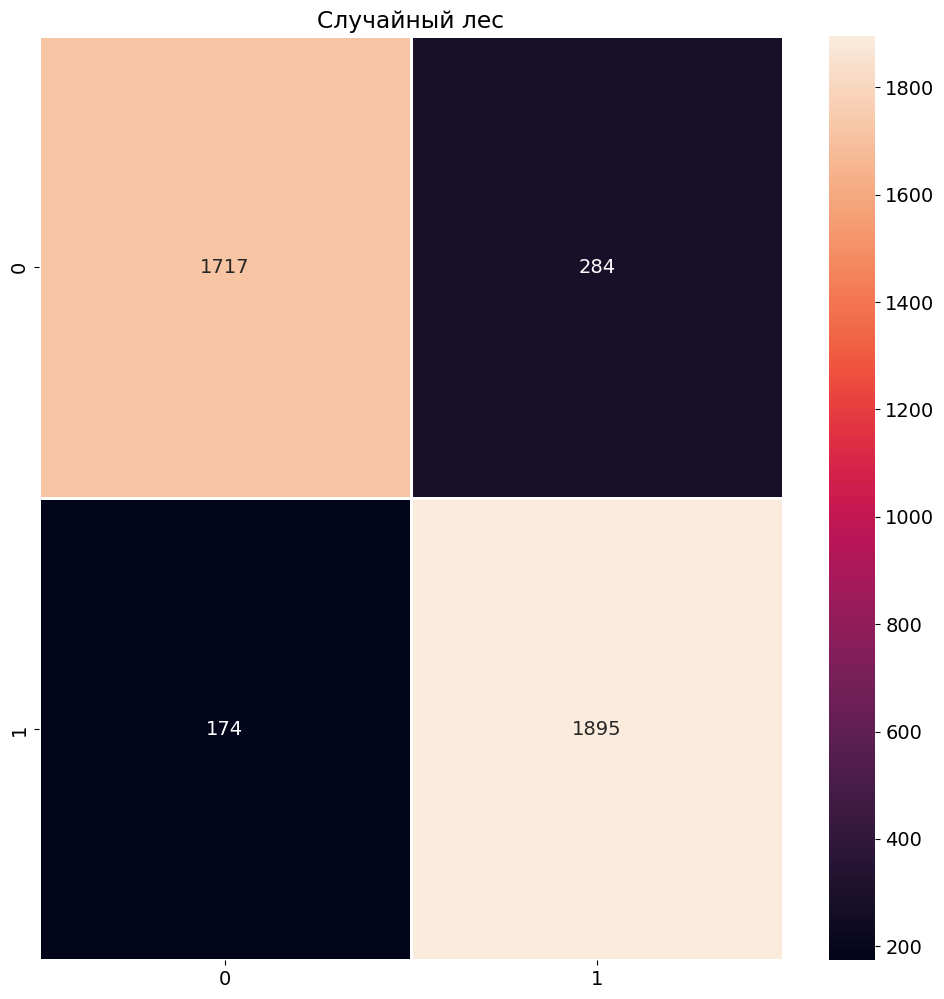

In [47]:
from cuml.ensemble import RandomForestClassifier 

rf = RandomForestClassifier()

rf.fit(x_train_balanced, y_train_balanced)

y_pred = rf.predict(x_test_balanced)
classification_report(y_test_balanced, y_pred)
show_confusion_matrix(y_test_balanced, y_pred, 'Случайный лес')


In [48]:
show_classification_report(y_test_balanced, y_pred)


    Accuracy:0.8875 
    Precision:0.8697
    Recall:0.9159
    F1: 0.8922
    AUC: 0.8870
    
    


In [49]:
# param_grid = {
#     'n_estimators': [100, 150, 250, 300],  
#     'split_criterion':[0,1],
#     'max_depth': [16, 32, 64],
#     'max_leaves':[2,4,8,16,32]
# }

# grid_search = GridSearchCV(
#     estimator=cuml.RandomForestClassifier(),
#     param_grid=param_grid,
#     scoring='accuracy',           # Метрика для оценки
#     cv=3,                         # Количество фолдов для кросс-валидации
#     verbose=1,                    # Уровень детализации вывода
#     n_jobs=-1                     # Использование всех доступных ядер CPU
# )

# grid_search.fit(x_train_balanced.to_cupy().get(), y_train_balanced.to_cupy().get())

# # Вывод лучших параметров и соответствующей точности
# print("Лучшие параметры:", grid_search.best_params_)
# print("Лучшая точность на кросс-валидации:", grid_search.best_score_)
# best_model = grid_search.best_estimator_

In [50]:
# y_pred = best_model.predict(x_test_balanced)
# classification_report(y_test_balanced, y_pred)
# show_confusion_matrix(y_test_balanced, y_pred, 'RandomForest')

## SVM

SVM:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      2001
           1       0.90      0.93      0.92      2069

    accuracy                           0.91      4070
   macro avg       0.91      0.91      0.91      4070
weighted avg       0.91      0.91      0.91      4070

AUC: 0.91350929175335


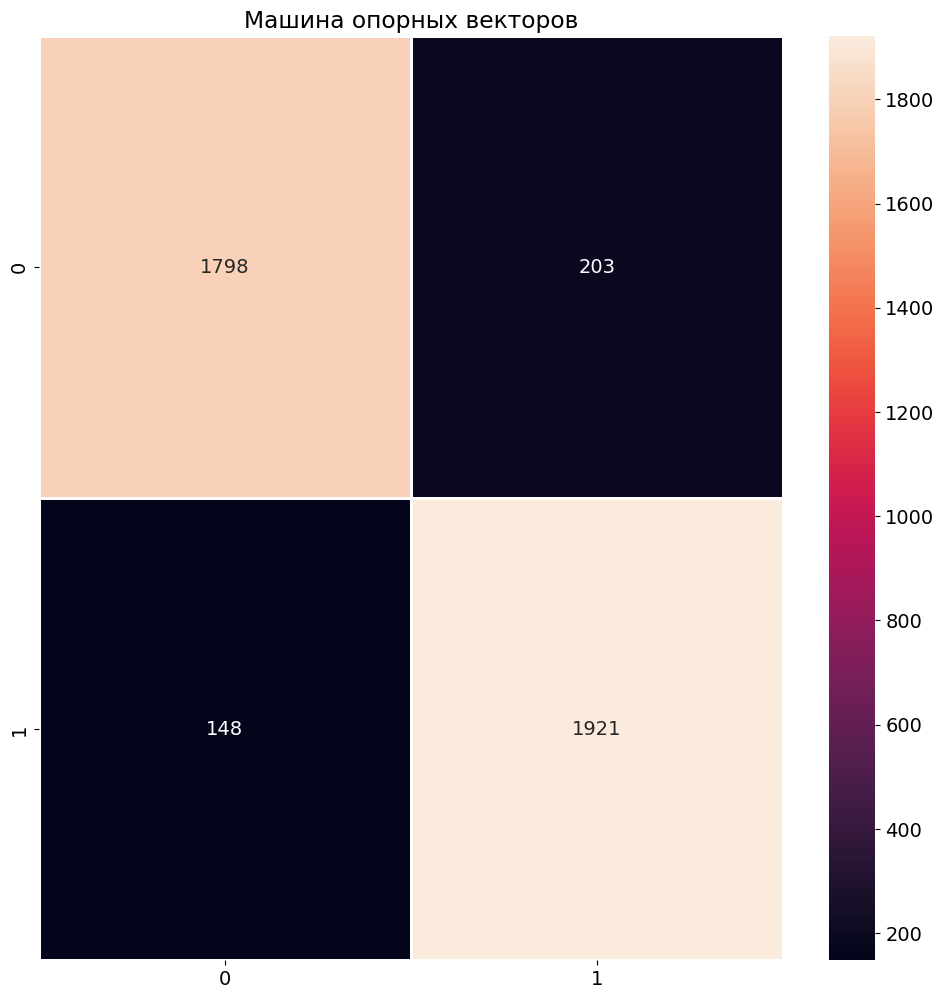

In [51]:
from cuml.svm import LinearSVC

svc = LinearSVC()

svc.fit(x_train_balanced.to_cupy(), y_train_balanced.to_cupy())

y_pred = svc.predict(x_test_balanced)
print('SVM:')
classification_report(y_test_balanced, y_pred)
show_confusion_matrix(y_test_balanced, y_pred, 'Машина опорных векторов')


In [52]:
show_classification_report(y_test_balanced, y_pred)


    Accuracy:0.9138 
    Precision:0.9044
    Recall:0.9285
    F1: 0.9163
    AUC: 0.9135
    
    


## MBSGDClassifier

In [53]:
from cuml import MBSGDClassifier

mbsgd = MBSGDClassifier()

mbsgd.fit(x_train_balanced.to_cupy(), y_train_balanced.to_cupy())

MBSGDClassifier()

MBSGDClassifier:
              precision    recall  f1-score   support

           0       0.94      0.86      0.89      2001
           1       0.87      0.94      0.91      2069

    accuracy                           0.90      4070
   macro avg       0.90      0.90      0.90      4070
weighted avg       0.90      0.90      0.90      4070

AUC: 0.9002694157995917


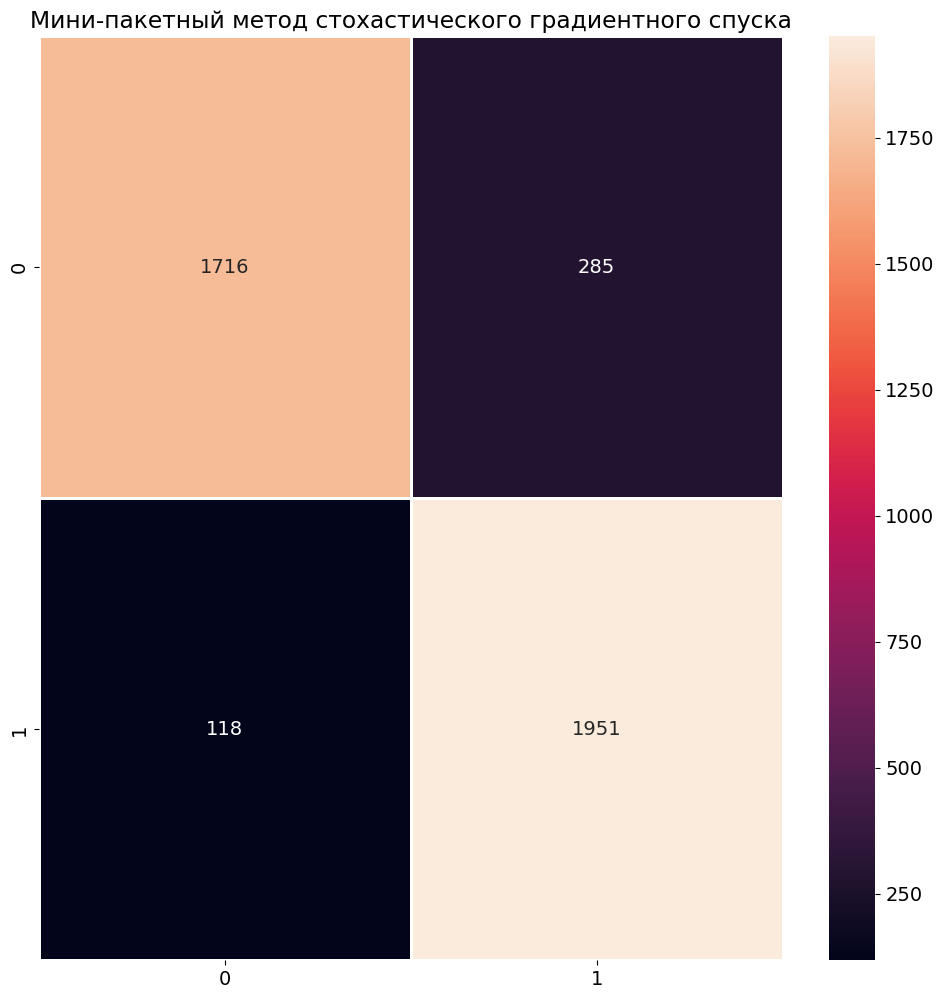

In [54]:
y_pred = mbsgd.predict(x_test_balanced)
print('MBSGDClassifier:')

classification_report(y_test_balanced, y_pred)
show_confusion_matrix(y_test_balanced, y_pred, 'Мини-пакетный метод стохастического градиентного спуска')

In [55]:
show_classification_report(y_test_balanced, y_pred)


    Accuracy:0.9010 
    Precision:0.8725
    Recall:0.9430
    F1: 0.9064
    AUC: 0.9003
    
    


## Naive Bayes

              precision    recall  f1-score   support

           0       0.78      0.82      0.80      2001
           1       0.81      0.77      0.79      2069

    accuracy                           0.79      4070
   macro avg       0.80      0.80      0.79      4070
weighted avg       0.80      0.79      0.79      4070

AUC: 0.7952223743130851


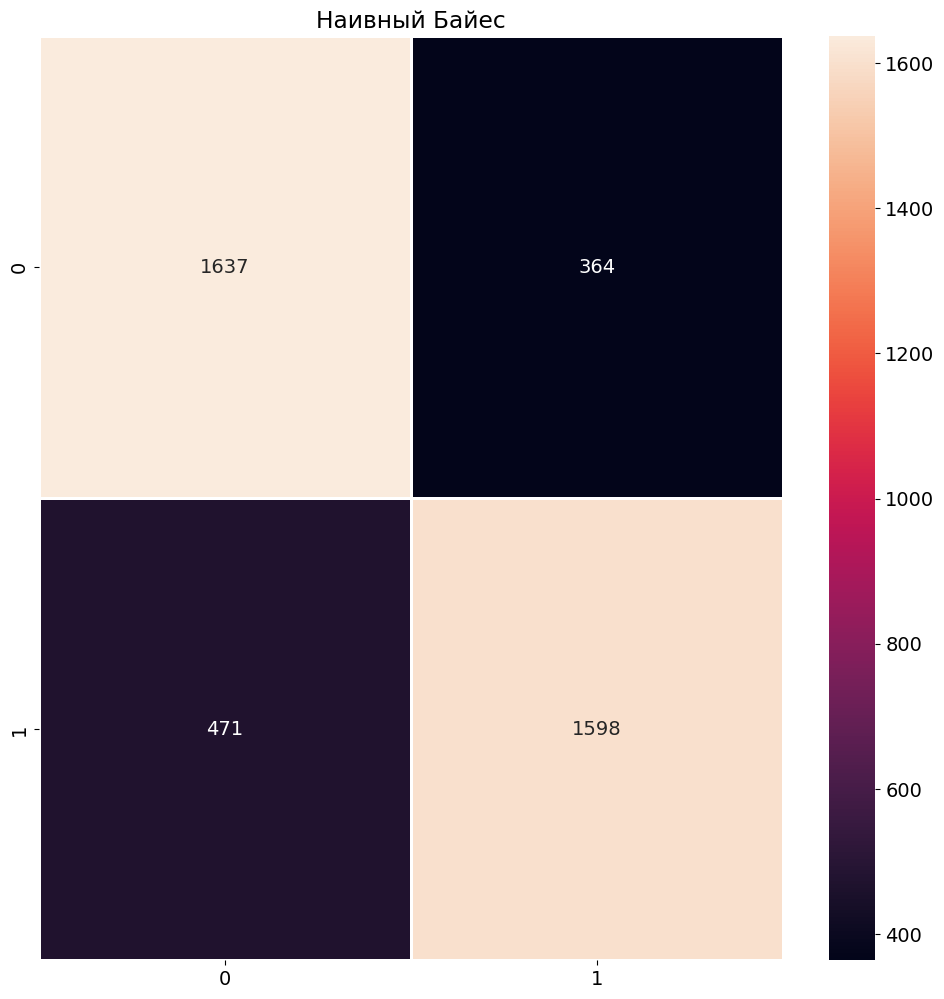

In [56]:
from cuml.naive_bayes import ComplementNB

nb = ComplementNB()

nb.fit(x_train_balanced.to_cupy(), y_train_balanced.to_cupy())
y_pred = nb.predict(x_test_balanced.to_cupy())

classification_report(y_test_balanced.to_cupy(), y_pred)
show_confusion_matrix(y_test_balanced.to_cupy(), y_pred, 'Наивный Байес')

## KNeighborsClassifier

KNN:
              precision    recall  f1-score   support

           0       0.75      0.08      0.14      2001
           1       0.52      0.97      0.68      2069

    accuracy                           0.53      4070
   macro avg       0.64      0.53      0.41      4070
weighted avg       0.63      0.53      0.42      4070

AUC: 0.5269220150678648


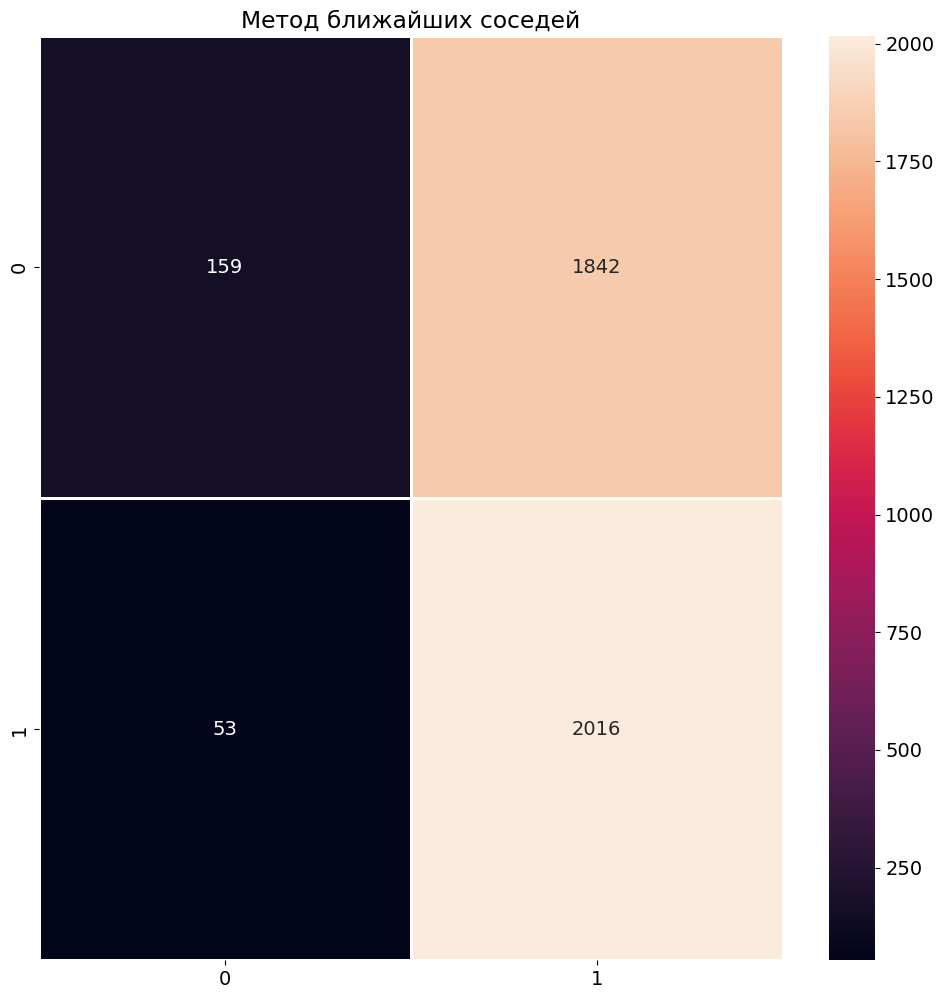

In [57]:
from cuml.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(x_train_balanced.to_cupy(), y_train_balanced.to_cupy())
y_pred = knn.predict(x_test_balanced)
print('KNN:')

classification_report(y_test_balanced, y_pred)
show_confusion_matrix(y_test_balanced, y_pred, 'Метод ближайших соседей')

In [58]:
show_classification_report(y_test_balanced, y_pred)


    Accuracy:0.5344 
    Precision:0.5226
    Recall:0.9744
    F1: 0.6803
    AUC: 0.5269
    
    


## Voting классификатор

In [59]:
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(
    estimators=[
        ('lr', lr),
        ('rf', rf),
        # ('svc', svc),
        ('mbsdg', mbsgd),
        ('nb', nb),
        # ('knn', knn)
    ],
    voting='hard' 
)

In [60]:
voting_clf.fit(x_train_balanced.to_cupy().get(), y_train_balanced.to_cupy().get())

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()),
                             ('mbsdg', MBSGDClassifier()),
                             ('nb', ComplementNB())])

In [61]:
# print("Тип данных для LR:", lr.predict(review_vector_test.todense().get()).dtype)
# print("Тип данных для RF:", rf.predict(review_vector_test.todense().get()).dtype)
# print("Тип данных для SVC:", svc.predict(review_vector_test.todense().get()).dtype)
# print("Тип данных для MBSGD:", mbsgd.predict(review_vector_test.todense().get()).dtype)
# print("Тип данных для NB:", nb.predict(review_vector_test.todense().get()).dtype)
# print("Тип данных для KNN:", knn.predict(review_vector_test.todense().get()).dtype)

Voting classifier:
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      2001
           1       0.90      0.92      0.91      2069

    accuracy                           0.91      4070
   macro avg       0.91      0.91      0.91      4070
weighted avg       0.91      0.91      0.91      4070

AUC: 0.9057350251891937


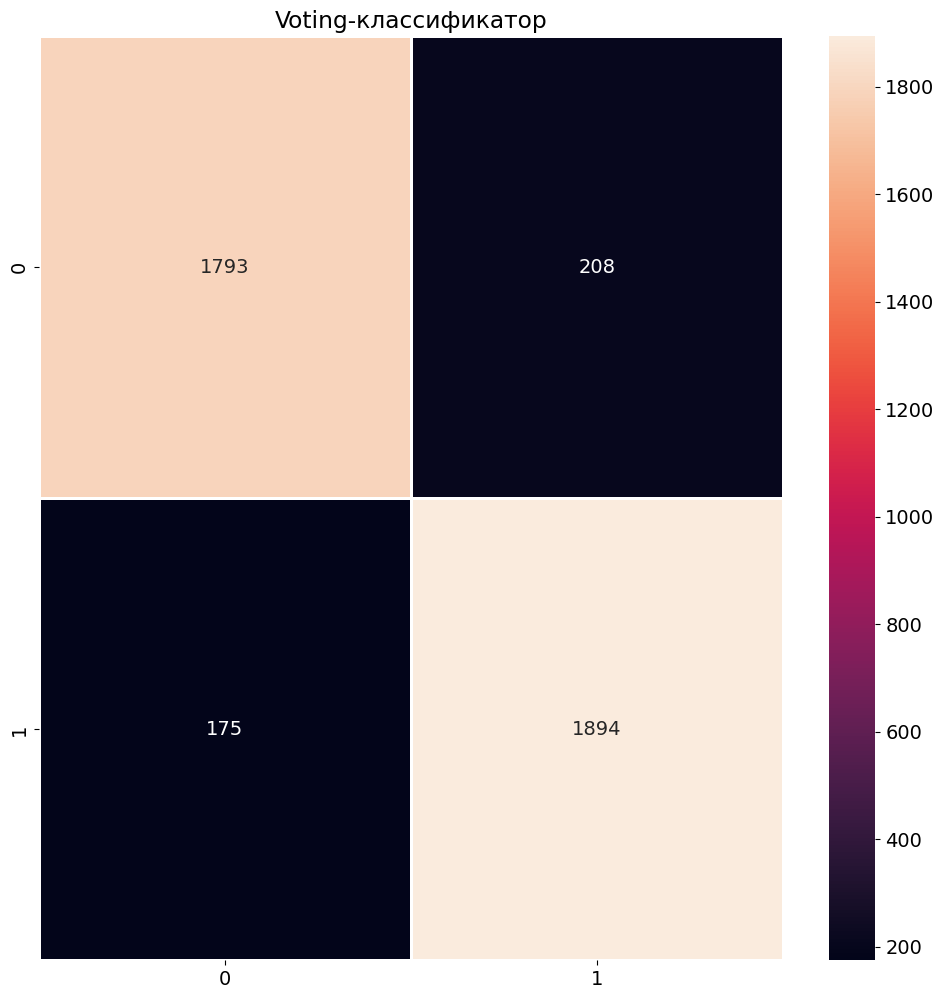

In [62]:
y_pred = voting_clf.predict(x_test_balanced.to_cupy().get())
print('Voting classifier:')
classification_report(y_test_balanced, y_pred)
show_confusion_matrix(y_test_balanced, y_pred, 'Voting-классификатор')

In [63]:
show_classification_report(y_test_balanced, y_pred)


    Accuracy:0.9059 
    Precision:0.9010
    Recall:0.9154
    F1: 0.9082
    AUC: 0.9057
    
    


# Сохранение сбалансированного датасета в файл

## TF-IDF векторы 

In [64]:
x_balanced.shape, y_balanced.shape

((16281, 1000), (16281,))

In [65]:
y_balanced.value_counts()

label
0    8141
1    8140
Name: count, dtype: int64

In [66]:
x_balanced.to_csv('yelp_chi_X_tf_idf_balanced.csv')

In [67]:
cudf.DataFrame(y_balanced)

,label
42888,1
50187,1
27251,1
9986,1
27486,1
...,...
61408,0
61409,0
61410,0
61411,0


In [68]:
cudf.DataFrame(y_balanced).to_csv('yelp_chi_y_labels_balanced.csv')

## Выборка из исходного датафрейма

In [69]:
balanced_origin_df = df_origin.loc[df_indices]
balanced_origin_df

,Unnamed: 0,date,review_id,user_id,prod_id,label,useful,funny,cool,rating,review
42888,42888,3/20/2011,VKnFAcl6qJiFIc-lDX-dIA,i7E48NFYrYduLu3x0baHVw,sDYjKyI_67eUhFAqVneYjA,1,2,0,1,4,fogo 2 go is a pretty solid pizza choice- and ...
50187,50187,8/8/2009,5FXsuSuRMNuA,xRJDiwMl_mlTgykx6gEARw,6gZTET0y7ARZMrbJRmI2mw,1,0,0,0,4,I sat in a bar and drank a Mickey's Grenade. I...
27251,27251,6/4/2009,qX5XcNpCsrkTp4U5r9Vt,3MpDvy5gEdsbZh9-p92dHg,cQnY_VneZisfUAqcbuEuKg,1,1,0,1,4,I have mixed feelings about Pequods. Every now...
9986,9986,3/25/2012,IElm86QnE9atMKCcnGHD3w,wWNRGu_q7Sien8SgoabE4g,JMa9cTNQA5mm4GbR2W8Oiw,1,0,0,1,5,"Pizza? Craft Beer? Hipsters? Check, check, aaa..."
27486,27486,9/19/2010,MHlH2ub5tWnyAmbuIKvA5g,ZHcDBcelF2HobBBhHGxEHQ,cQnY_VneZisfUAqcbuEuKg,1,2,0,2,1,Since I've relocated from upstate New York to ...
...,...,...,...,...,...,...,...,...,...,...,...
47712,47712,8/25/2010,jGbgfF3DauuS0UHuOPHhsA,uZmTu3k96zztq0KYIenZXQ,d6UbRb9W5eA1yL-DuVZ8ug,1,0,0,1,5,"My husband and I got married on July 10, 2011 ..."
41953,41953,8/20/2012,FD2i,6VKK6L4BP4rQqKYZSkL1eg,tW2jfL-qMccAYZSghPBbHA,1,0,0,1,5,The best Chicago style pizza I ever had! This ...
7848,7848,6/5/2011,l9iwr6BlN-X4XbV,fJu2zEi0_5vhXqOtUK6wdA,43rd1LKcZRIunySzbMsyLQ,1,0,0,0,5,Spacca Napoli is my go-to neighborhood restaur...
28728,28728,9/13/2009,G61zWTnE6EwXSctWOGhcWA,bQxvdzxQGFgTfp-kYznOfA,AqgG-1aD6JYj9D6OmBWO3w,1,0,0,0,5,Best pizza I have ever had. I had to start tal...


In [70]:
balanced_origin_df['label'].value_counts()

label
1    8140
Name: count, dtype: int64

In [71]:
origin_fake = df_origin[df_origin['label'] == -1]

In [72]:
balanced_origin_df=  cudf.concat([balanced_origin_df, origin_fake], axis=0)
balanced_origin_df

,Unnamed: 0,date,review_id,user_id,prod_id,label,useful,funny,cool,rating,review
42888,42888,3/20/2011,VKnFAcl6qJiFIc-lDX-dIA,i7E48NFYrYduLu3x0baHVw,sDYjKyI_67eUhFAqVneYjA,1,2,0,1,4,fogo 2 go is a pretty solid pizza choice- and ...
50187,50187,8/8/2009,5FXsuSuRMNuA,xRJDiwMl_mlTgykx6gEARw,6gZTET0y7ARZMrbJRmI2mw,1,0,0,0,4,I sat in a bar and drank a Mickey's Grenade. I...
27251,27251,6/4/2009,qX5XcNpCsrkTp4U5r9Vt,3MpDvy5gEdsbZh9-p92dHg,cQnY_VneZisfUAqcbuEuKg,1,1,0,1,4,I have mixed feelings about Pequods. Every now...
9986,9986,3/25/2012,IElm86QnE9atMKCcnGHD3w,wWNRGu_q7Sien8SgoabE4g,JMa9cTNQA5mm4GbR2W8Oiw,1,0,0,1,5,"Pizza? Craft Beer? Hipsters? Check, check, aaa..."
27486,27486,9/19/2010,MHlH2ub5tWnyAmbuIKvA5g,ZHcDBcelF2HobBBhHGxEHQ,cQnY_VneZisfUAqcbuEuKg,1,2,0,2,1,Since I've relocated from upstate New York to ...
...,...,...,...,...,...,...,...,...,...,...,...
61408,61408,3/2/2012,Hr0bENBZzznWhYGKSSEEJA,i2Th0Zskb4Ry_aVZQMIR_Q,mCHto10PBQOKnefm7gholg,-1,0,0,0,5,"Great food and good service. It's BYOB, so bri..."
61409,61409,2/18/2012,qGvPCsS3krxl5O5fo9Qasw,UqTtumV5SGzzW2gtJc-fNg,mCHto10PBQOKnefm7gholg,-1,0,0,0,1,This is a must dine restaurant. After we saw t...
61410,61410,12/31/2011,znZdvMF_Q-rCT3ih3-AQAg,Y-yZy5TWmWrC6mlY_BaseQ,mCHto10PBQOKnefm7gholg,-1,0,0,0,5,I came here about 5 times and the food is alwa...
61411,61411,12/17/2011,tgbjSaEGOGyV6q1y13Mi8Q,Yva1UlQvZ-MGfJEQMWrk8Q,mCHto10PBQOKnefm7gholg,-1,0,0,0,5,So delicious! Ordered this in and got yellow c...


In [73]:
balanced_origin_df.to_csv('yelp_chi_kmeans_balancing.csv')